{% include toc title="On This Page" icon="file-text" %}

<div class='notice--success' markdown="1">

## <i class="fa fa-graduation-cap" aria-hidden="true"></i> Learning Objectives

* Explore a raster and produce histograms to help define appropriate raster break points for classification.
* Reclassify a raster dataset in **Python** using a set of defined values and `np.digitize`. 

</div>

### Manually Reclassify Raster Data 

In this lesson, you will learn how to reclassify a raster dataset in **Python**. When you reclassify
a raster, you create a **new** raster object / file that can be exported and shared with colleagues and / or open in other tools such as QGIS. 

In that raster, each pixel is mapped to a new value based on some approach. This approach can vary depending upon your science question.


<figure>
    <a href="{{ site.url }}/images/earth-analytics/raster-data/reclass-raster-esri.gif">
    <img src="{{ site.url }}/images/earth-analytics/raster-data/reclass-raster-esri.gif" alt="Example of reclassification process from ESRI."></a>
    <figcaption> When you reclassify a raster, you create a new raster. In that raster, each cell from the old raster is mapped to the new raster. The values in the new raster are applied using a defined range of values or a raster map. For example above you can see that all cells that
contains the values 1-3 are assigned the new value of 5. <a href="http://resources.esri.com/help/9.3/arcgisdesktop/com/gp_toolref/geoprocessing_with_3d_analyst/Reclass_Reclass2.gif">Source: ESRI</a>
    </figcaption>
</figure>

## Raster Classification Steps

You can break your raster processing workflow into several steps as follows:

* **Data import / cleanup:** load and "clean" the data. This includes cropping, removing with `nodata` values
* **Data Exploration:** understand the range and distribution of values in your data. This may involve plotting histograms and scatter plots to determine what classes are appropriate for our data
* **Reclassify the Data:** Once you understand the distribution of your data, you are ready to reclassify. There are statistical and non-statistical approaches to reclassification. Here you will learn how to manually reclassify a raster using bins that you define in your data exploration step. 

Please note - working with data is not a linear process. Above you see a potential workflow. You will develop your own workflow and approach.  

To get started, first load the required libraries and then open up your raster. In this case, you are using the lidar canopy height model (CHM) that you calculated in the previous lesson.

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import os

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, BoundaryNorm
import numpy as np
import xarray as xr
import rioxarray as rxr
import earthpy as et
import earthpy.plot as ep

# Prettier plotting with seaborn
import seaborn as sns
sns.set(font_scale=1.5, style="whitegrid")

# Get data and set working directory
et.data.get_data("colorado-flood")
os.chdir(os.path.join(et.io.HOME,
                      'earth-analytics',
                      'data'))

To begin, open the `lidar_chm.tif` file that you created in the previous lesson, or recreate it using the code below.

In [3]:
# Define relative paths to DTM and DSM files
# dtm_path = os.path.join("colorado-flood",
#                         "spatial",
#                         "boulder-leehill-rd",
#                         "pre-flood",
#                         "lidar",
#                         "pre_DTM.tif")

# dsm_path = os.path.join("colorado-flood",
#                         "spatial",
#                         "boulder-leehill-rd",
#                         "pre-flood",
#                         "lidar",
#                         "pre_DSM.tif")

# # Open DTM and DSM files
# with rio.open(dtm_path) as src:
#     lidar_dtm_im = src.read(1, masked=True)
#     spatial_extent = plotting_extent(src)

# with rio.open(dsm_path) as src:
#     lidar_dsm_im = src.read(1, masked=True)
#     spatial_extent = plotting_extent(src)

# # Create canopy height model (CHM)
# lidar_chm_im = lidar_dsm_im - lidar_dtm_im
# lidar_chm_im

In [4]:
# Define relative paths to DTM and DSM files
dtm_path = os.path.join("colorado-flood",
                        "spatial",
                        "boulder-leehill-rd",
                        "pre-flood",
                        "lidar",
                        "pre_DTM.tif")

dsm_path = os.path.join("colorado-flood",
                        "spatial",
                        "boulder-leehill-rd",
                        "pre-flood",
                        "lidar",
                        "pre_DSM.tif")

# Open DTM and DSM files
pre_lidar_dtm = rxr.open_rasterio(dtm_path, masked=True).squeeze()
pre_lidar_dsm = rxr.open_rasterio(dsm_path, masked=True).squeeze()

# Create canopy height model (CHM)
pre_lidar_chm = pre_lidar_dsm - pre_lidar_dtm
pre_lidar_chm

<xarray.DataArray (y: 2000, x: 4000)>
array([[       nan,        nan,        nan, ..., 0.        , 0.17004395,
        0.96008301],
       [       nan,        nan,        nan, ..., 0.        , 0.09008789,
        1.64001465],
       [       nan,        nan,        nan, ..., 0.        , 0.        ,
        0.07995605],
       ...,
       [       nan,        nan,        nan, ..., 0.        , 0.        ,
        0.        ],
       [       nan,        nan,        nan, ..., 0.        , 0.        ,
        0.        ],
       [       nan,        nan,        nan, ..., 0.        , 0.        ,
        0.        ]])
Coordinates:
    band         int64 1
  * y            (y) float64 4.436e+06 4.436e+06 ... 4.434e+06 4.434e+06
  * x            (x) float64 4.72e+05 4.72e+05 4.72e+05 ... 4.76e+05 4.76e+05
    spatial_ref  int64 0

In [5]:
# open raster data
# with rio.open('data/colorado-flood/spatial/outputs/lidar_chm.tiff') as lidar_chm:
#     lidar_chm_im = lidar_chm.read(1, masked=True)

# # get spatial extent for plotting
# bounds = plotting_extent(lidar_chm)

### What Classification Values to Use?

There are many different approaches to classification. Some use highly sophisticated spatial algorithms that identify patterns in the data that can in turn be used to classify particular pixels into particular "classes". 

In this case, you are simply going to create the classes manually using the range of quantitative values found in our data.

Assuming that our data represent trees (though you know there are likely some buildings in the data), classify your raster into 3 classes:

* Short trees
* Medium trees
* Tall trees

To perform this classification, you need to understand which values represent short trees vs medium trees vs tall trees in your raster. This is where histograms can be extremely useful.

Start by looking at the min and max values in your CHM.

In [6]:
# View min and max values in the data
print('CHM min value:', np.nanmin(pre_lidar_chm))
print('CHM max value:', np.nanmax(pre_lidar_chm))

CHM min value: 0.0
CHM max value: 26.9300537109375


### Get to Know Raster Summary Statistics 

Get to know your data by looking at a histogram. A histogram quantifies
the distribution of values found in your data.

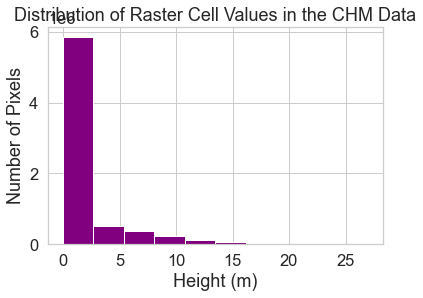

In [7]:
f, ax = plt.subplots()
pre_lidar_chm.plot.hist(color="purple")
ax.set(title="Distribution of Raster Cell Values in the CHM Data",
       xlabel="Height (m)",
       ylabel="Number of Pixels")
plt.show()

In [8]:
# fig, ax = plt.subplots(figsize =(14,14))

# # Set a custom range
# ax.hist(lidar_chm_cleaned_hist, color='purple', edgecolor='white',
#         range=[np.nanmin(lidar_chm_cleaned_hist),
#                np.nanmax(lidar_chm_cleaned_hist)])

# ax.set_title("Distribution of raster cell values in the DTM difference data",
#              fontsize = 16)
# ax.set(xlabel="Height (m)", ylabel="Number of Pixels");

In [9]:
# print(np.nanmin(lidar_chm_cleaned_hist))
# print(np.nanmax(lidar_chm_cleaned_hist))

### Explore Raster Histograms

Further explore your histogram, by constraining the x axis limits using the `xlim` and `ylim` parameters. 

These lim parameters visually zooms in on the data in the plot. It does not modify the data.

You might also chose to adjust the number of bins in your plot. Below you plot a bin for each increment on the x axis calculated using:

`hist_range(*xlim)`

You could also set `bins = 100` or some other value if you wish.

In [10]:
# # Create histogram with xlim and ylim
# xlim = [0, 25]

# # f, ax = ep.hist(lidar_chm_im.ravel(),
# #                 hist_range=xlim,
# #                 bins=range(*xlim),
# #                 ylabel="Number of Pixels", xlabel="Height (m)",
# #                 title="Distribution of raster cell values in the DTM difference data \n" +
# #                       "Zoomed in to {} on the x axis".format(xlim))
# f, ax = plt.subplots()
# pre_lidar_chm.plot.hist(color="purple",
#                         bins=range(*xlim),
#                         range=[0, 15])
# ax.set(title="Distribution of raster cell values in the DTM difference data \n " +
#        "Zoomed in to {} on the x axis".format(xlim),
#        xlabel="Height (m)",
#        ylabel="Number of Pixels")
# plt.show()


# ax.set(xlim=xlim, ylim=[0, 250000])

# plt.show()

You can look at the values that **Python** used to draw your histogram, too. 

To do this, you can collect the outputs that are returned when you call `np.histogram`. This consists of two things:

* `counts`, which represents the number of items in each bin
* `bins`, which represents the edges of the bins (there will be one extra item in bins compared to counts)

Each bin represents a bar on your histogram plot. Each bar represents the frequency or number of pixels that have a value within that bin. 

Notice that you have adjusted the `xlim` and `ylim` to zoom into the region of the histogram that you are interested in exploring; however, the values did not actually change.


In [11]:
# # Get counts and bins
# counts, bins = np.histogram(lidar_chm_im,
#                             bins=50,
#                             range=xlim)

# print("counts:", counts)
# print("bins:", bins)

### Histogram with Custom Breaks

Customize your histogram with breaks that you think might make sense 
as breaks to use for your raster map. 

In the example below, breaks are added in 5 meter increments using the `bins =` argument. 

`bins=[0, 5, 10, 15, 20, 30]`

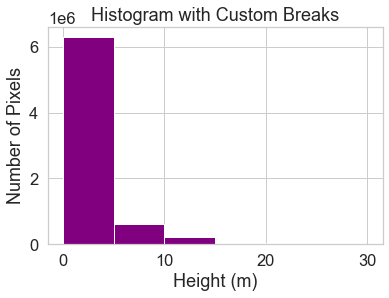

In [12]:
# Histogram with custom breaks
f, ax = plt.subplots()
pre_lidar_chm.plot.hist(color="purple",
                        bins=[0, 5, 10, 15, 20, 30])
ax.set(title="Histogram with Custom Breaks",
       xlabel="Height (m)",
       ylabel="Number of Pixels")

plt.show()

You may want to play with the distribution of breaks. Below it appears as if there are many values close to 0. 

In the case of this lidar instrument, you know that values between 0 and 2 meters are not reliable (you know this if you read the documentation about the NEON sensor and how these data were processed). 

Below you create a bin between 0-2.

You also know you want to create bins for short, medium and tall trees, so experiment with those bins as well.

Below following breaks are used:
* 0 - 2 = no trees
* 2 - 7 = short trees
* 7 - 12 = medium trees
* `>` 12 = tall trees

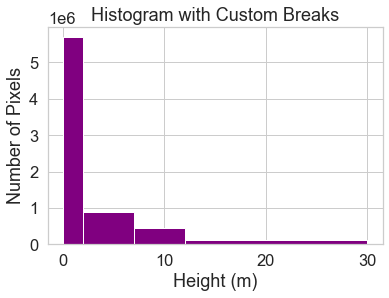

In [13]:
# Histogram with custom breaks
f, ax = plt.subplots()

pre_lidar_chm.plot.hist(
    color='purple',
    bins=[0, 2, 7, 12, 30])
ax.set(title="Histogram with Custom Breaks",
       xlabel="Height (m)",
       ylabel="Number of Pixels")

plt.show()

You may want to play around with the setting specific bins associated with your science question and the study area. To begin, use the classes above to reclassify your CHM raster.


## Map Raster Values to New Values

To reclassify your raster, first you need to create a reclassification matrix. 

This matrix **MAPS** a range of values to a new defined value. You will use this matrix to create a classified
canopy height model where you designate short, medium and tall trees.

The newly defined values will be as follows:

* No trees: (0m - 2m tall) = NA
* Short trees: (2m - 7m tall) = 1
* Medium trees: (7m - 12m tall) = 2
* Tall trees:  (> 12m tall) = 3

Notice in the list above that you set cells with a value between 0 and 2 meters to
NA or `nodata` value. This means you are assuming that there are no trees in those
locations!

Notice in the matrix below that you use `Inf` to represent the largest or max value
found in the raster. So our assignment is as follows:

* 0 - 2 meters -> 1
* 2 - 7 meters -> 2 (short trees)
* 7 - 12 meters -> 3 (medium trees)
* `>` 12 or 12 - Inf -> 4 (tall trees)

Below you create the matrix.

<!-- https://github.com/EarthScientist/AK_LandCarbon/blob/master/new_rasterio_stuff.py this is an examiple of how to reclassify...-->


### `np.digitize`

**Numpy** has a function called `digitize` that is useful for classifying the values in an array. It is similar to how `histogram` works, because it categorizes datapoints into bins. However, unlike `histogram`, it doesn't aggregate/count the number of values within each bin.

Instead, `digitize` will replace each datapoint with an integer corresponding to which bin it belongs to. You can use this to determine which datapoints fall within certain ranges. 

When you use `np.digitize`, the bins that you create work as follows:
* The starting value by default is included in each bin. The ending value of the bin is not and will be the beginning of the next bin. You can add the argument `right = True` if you want the second value in the bin to be included but not the first. 
* Any values BELOW the bins as defined will be assigned a `0`. Any values ABOVE the highest value in your bins will be assigned the next value available. Thus, if you have:

`class_bins = [0, 2, 7, 12, 30]`

Any values that are equal to 30 or larger will be assigned a value of `5`. Any values that are `< 0` will be assigned a value of `0`.

Oftentimes, you can use `np.inf` in your array to include all values greater than the last value, and you can use `-np.inf` in your array to include all values less than the first value.

However, if you are using the class bins for a `BoundaryNorm` object for a plot,`np.inf` will throw an error in **matplotlib**. The `BoundaryNorm` object cannot handle an infinity value, so you must supply it with an actual integer. 

A good stand in for `np.inf` is the maximum value numpy can store as an integer, which can be accessed by using `np.iinfo(np.int32).max`. This will have the same effect as `np.inf` without breaking the `BoundaryNorm` object.

Likewise, you can use the minimum value of the array (`arr.min()`) instead of `-np.inf`.

In [14]:
# Check nodata value for your array
pre_lidar_chm.rio.nodata

Below you define 4 bins. However, you end up with a `fifth class == 0` which represents values smaller than `0` which is the minimum value in your chm. 

These values < 0 come from the **numpy** mask fill value which you can see identified above this text.

In [15]:
data_min_value = np.nanmin(pre_lidar_chm)
data_max_value = np.nanmax(pre_lidar_chm)
print(data_min_value, data_max_value)

0.0 26.9300537109375


In [16]:
class_bins = [-np.inf, 2, 7, 12, np.inf]
class_bins

[-inf, 2, 7, 12, inf]

In [17]:
# %%timeit
# # Classify your data
# pre_lidar_chm_class = xr.apply_ufunc(np.digitize,
#                                      pre_lidar_chm,
#                                      class_bins)
# # View unique values in the data - notice there are 5 classes yet you have 4 bins
# #np.unique(pre_lidar_chm_class)

In [18]:
pre_lidar_chm_class = xr.apply_ufunc(np.digitize,
                                     pre_lidar_chm,
                                     class_bins)

In [19]:
# Define bins that you want, and then classify the data
# pre_lidar_chm_class = pre_lidar_chm.copy()
# canopy_height_classes = np.digitize(pre_lidar_chm, class_bins)
# canopy_height_classes
# Classify the original image array, then unravel it again for plotting
# lidar_chm_im_class = np.digitize(pre_lidar_chm, class_bins)

# # Note that you have an extra class in the data (0)
# print(np.unique(lidar_chm_im_class))

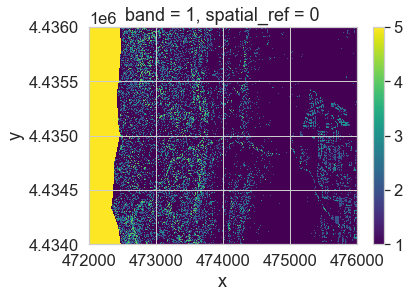

In [20]:
# Values of 5 represent missing data
im = pre_lidar_chm_class.plot.imshow()
ax.set_axis_off()

After running the classification, you have one extra class. This class - the first class - is your missing data value. Your classified array output is also a regular (not a masked) array. 

You can reassign the first class in your data to a mask using `xarray .where()`.

In [21]:
# Mask out values not equalt to 5
pre_lidar_chm_class_ma = pre_lidar_chm_class.where(pre_lidar_chm_class != 5)
pre_lidar_chm_class_ma

<xarray.DataArray (y: 2000, x: 4000)>
array([[nan, nan, nan, ...,  1.,  1.,  1.],
       [nan, nan, nan, ...,  1.,  1.,  1.],
       [nan, nan, nan, ...,  1.,  1.,  1.],
       ...,
       [nan, nan, nan, ...,  1.,  1.,  1.],
       [nan, nan, nan, ...,  1.,  1.,  1.],
       [nan, nan, nan, ...,  1.,  1.,  1.]])
Coordinates:
    band         int64 1
  * y            (y) float64 4.436e+06 4.436e+06 ... 4.434e+06 4.434e+06
  * x            (x) float64 4.72e+05 4.72e+05 4.72e+05 ... 4.76e+05 4.76e+05
    spatial_ref  int64 0

In [22]:
# Reassign all values that are classified as 0 to masked (no data value)
# This will prevent pixels that == 0 from being rendered on a map in matplotlib
# lidar_chm_class_ma = np.ma.masked_where(lidar_chm_im_class == 0,
#                                         lidar_chm_im_class,
#                                         copy=True)
# lidar_chm_class_ma

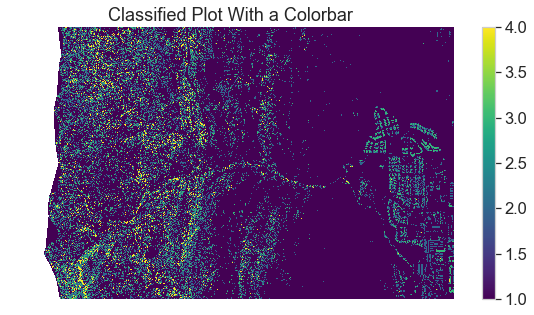

In [23]:
# Plot newly classified and masked raster
f, ax = plt.subplots(figsize=(10,5))
pre_lidar_chm_class_ma.plot.imshow()
ax.set(title="Classified Plot With a Colorbar")

ax.set_axis_off()
plt.show()

Below the raster is plotted with slightly improved colors

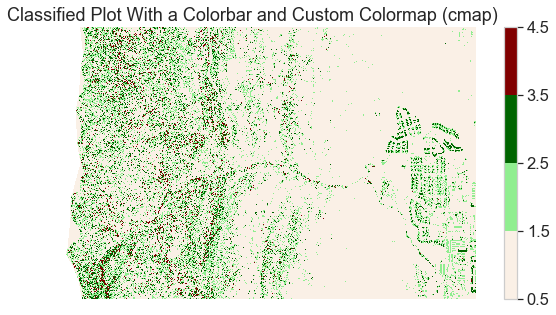

In [24]:
# Plot data using nicer colors
colors = ['linen', 'lightgreen', 'darkgreen', 'maroon']
class_bins = [.5, 1.5, 2.5, 3.5, 4.5]
cmap = ListedColormap(colors)
norm = BoundaryNorm(class_bins, 
                    len(colors))

# Plot newly classified and masked raster
f, ax = plt.subplots(figsize=(10, 5))
pre_lidar_chm_class_ma.plot.imshow(cmap=cmap,
                                   norm=norm)
ax.set(title="Classified Plot With a Colorbar and Custom Colormap (cmap)")
ax.set_axis_off()
plt.show()


## Add a Custom Legend to Your Plot with EarthPy

The plot looks OK but the legend does not represent the data well. The legend is continuous - with a range between 1.0 and 4.0 However, you want to plot the data using discrete bins.

Given you have discrete values, you can create a custom legend with the four categories that you created in your classification matrix.

There are a few tricky pieces to creating a custom legend.

1. Notice below that you first create a list of legend items (or labels):

`height_class_labels = ["Short trees", "Less short trees", "Medium trees", "Tall trees"]`

This represents the text that will appear in your legend. 

2. Next you create the colormap from a list of colors. 

This code: `colors = ['linen', 'lightgreen', 'darkgreen', 'maroon']` creates the color list.

And this code: `cmap = ListedColormap(colors)` creates the colormap to be used in the plot code.  

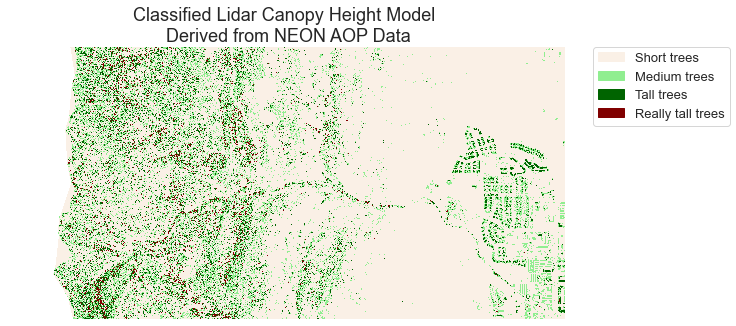

In [25]:
# Create a list of labels to use for your legend
height_class_labels = ["Short trees",
                       "Medium trees",
                       "Tall trees",
                       "Really tall trees"]

# Create a colormap from a list of colors
colors = ['linen',
          'lightgreen',
          'darkgreen',
          'maroon']

cmap = ListedColormap(colors)

class_bins = [.5, 1.5, 2.5, 3.5, 4.5]
norm = BoundaryNorm(class_bins,
                    len(colors))

# Plot newly classified and masked raster
f, ax = plt.subplots(figsize=(10, 5))
im = pre_lidar_chm_class_ma.plot.imshow(cmap=cmap,
                                        norm=norm,
                                        # Turn off colorbar
                                        add_colorbar=False)
# Add legend using earthpy
ep.draw_legend(im,
               titles=height_class_labels)
ax.set(title="Classified Lidar Canopy Height Model \n Derived from NEON AOP Data")
ax.set_axis_off()
plt.show()

<div class="notice--warning" markdown="1">

## <i class="fa fa-pencil-square-o" aria-hidden="true"></i> Optional Challenge: Plot Change Over Time

1. Create a classified raster map that shows **positive and negative change**
in the canopy height model before and after the flood. To do this you will need
to calculate the difference between two canopy height models.
2. Create a classified raster map that shows **positive and negative change**
in terrain extracted from the pre and post flood Digital Terrain Models before
and after the flood.

For each plot, be sure to:

* Add a legend that clearly shows what each color in your classified raster represents.
* Use better colors than I used in my example above!
* Add a title to your plot.

You will include these plots in your final report due next week.

Check out <a href="https://matplotlib.org/users/colormaps.html" target="_blank">this cheatsheet for more on colors in `matplotlib`. </a>


</div>